In [25]:
from __future__ import print_function
import numpy as np
import glob
import pandas as pd
from random import shuffle,seed

seed(2017)
np.random.seed(2017)

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib.pyplot as plt
#from keras.preprocessing.image import ImageDataGenerator
import cv2
WIDTH  = 86
HEIGHT = 64

batch_size = 16
num_classes = 3
epochs = 20


print( tensorflow.__version__,keras.__version__)

1.3.0 2.0.8


In [26]:
def build_train_set():
    
    dataset = []
    
    colors = {"red": 0, "yellow":1, "green": 2 }
    
    for color in colors.keys():
        path = "/disk/projects/selfdriving/shared/img5/%s/*.jpg" % color
        print(path)
        images =  glob.glob(path)     
        
        for im_file in images:
            label = colors[color]
            img = cv2.imread(im_file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize( img, (WIDTH, HEIGHT))
            ## flip image for data augmentation
            img2 = cv2.flip( img.copy(), 1 )

            dataset.append( (np.array(img), label))
            dataset.append( (np.array(img2), label))

    shuffle(dataset)
        
    return np.array(dataset)

In [27]:
dataset = build_train_set()

len(dataset)

/disk/projects/selfdriving/shared/img5/green/*.jpg
/disk/projects/selfdriving/shared/img5/yellow/*.jpg
/disk/projects/selfdriving/shared/img5/red/*.jpg


1152

In [28]:
r = np.random.rand( dataset.shape[0])
train = dataset[r<.8]
test = dataset[r>=.8]

In [29]:
train.shape, test.shape
x_train = np.array([ img for img in train[:,0]])
y_train = train[:,1]

x_test = np.array([ img for img in test[:,0]])
y_test = test[:,1]

In [30]:
# input image dimensions
img_rows, img_cols = HEIGHT, WIDTH


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (926, 64, 86, 3)
926 train samples
226 test samples


In [6]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks =[es]
         )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (926, 64, 86, 3)
926 train samples
226 test samples
Train on 926 samples, validate on 226 samples
Epoch 1/20
926/926 [==============================] - 32s - loss: 0.9668 - acc: 0.5508 - val_loss: 0.8353 - val_acc: 0.5929
Epoch 2/20
926/926 [==============================] - 32s - loss: 0.7857 - acc: 0.6598 - val_loss: 0.6687 - val_acc: 0.5575
Epoch 3/20
926/926 [==============================] - 33s - loss: 0.4540 - acc: 0.8348 - val_loss: 0.2827 - val_acc: 0.8850
Epoch 4/20
926/926 [==============================] - 33s - loss: 0.2168 - acc: 0.9320 - val_loss: 0.1376 - val_acc: 0.9779
Epoch 5/20
926/926 [==============================] - 33s - loss: 0.0827 - acc: 0.9741 - val_loss: 0.0639 - val_acc: 0.9735
Epoch 6/20
926/926 [==============================] - 35s - loss: 0.0495 - acc: 0.9860 - val_loss: 0.0324 - val_acc: 0.9867
Epoch 7/20
926/926 [==============================] - 40s - loss: 0.0283 - acc: 0.9935 - val_loss: 0.0212 - val_acc: 0.9912
Epoch 8/20
926/926 

In [7]:
model.save("/disk/projects/selfdriving/shared/model/model_6_keep_aspect_ratio.hd5")

In [8]:
WIDTH, HEIGHT

(86, 64)

In [24]:
ret = model.predict( x_test[123].reshape( 1, HEIGHT, WIDTH, 3) )

NameError: name 'x_test' is not defined

In [35]:
ret

array([[ 0.02071507,  0.87610024,  0.10318466]], dtype=float32)

In [11]:
np.argmax(ret)

0

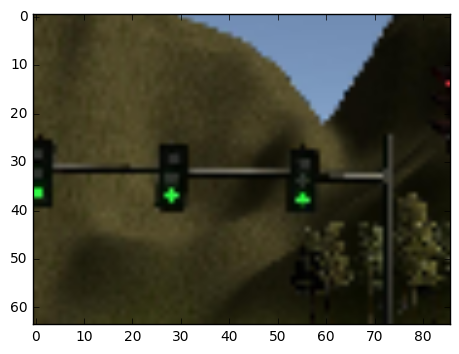

In [37]:
plt.imshow( x_test[121])

In [1]:
del model

from keras.models import load_model
model = load_model("/disk/projects/selfdriving/shared/model/model_6_keep_aspect_ratio.hd5")

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [38]:
%time ret = model.predict( x_test[121].reshape( 1, HEIGHT, WIDTH, 3) )

CPU times: user 41.9 ms, sys: 0 ns, total: 41.9 ms
Wall time: 12.3 ms


In [39]:
ret, np.argmax(ret)

(array([[  2.32019744e-07,   2.47415983e-06,   9.99997258e-01]], dtype=float32),
 2)

In [33]:
images = glob.glob("/disk/projects/selfdriving/shared/img5/yellow/*.jpg")
results = []
for im_file in images:
    test_img = cv2.imread(im_file)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize( test_img, (WIDTH, HEIGHT))
    test_img = test_img.astype('float32')/255
    test_img
    ret = model.predict( test_img.reshape( 1, HEIGHT, WIDTH, 3) )
    results.append( np.argmax(ret))


In [34]:
results= np.array(results)
results[results<>1].shape

(0,)